# Convolving Lena GPU

- Describes convolution
- Writes convolution algorithms
- Compares with ImageFilter
- Tries to import to GPU

In [1]:
using OffsetArrays
using StaticArrays
using Images
using FileIO
using Printf

In [2]:
using HDF5

In [4]:
import Pkg; Pkg.add("FFTW")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed Rmath_jll ─ v0.2.2+2
Updating `/volumedisk0/home/gomez/JuliaProjects/JImages/Project.toml`
  [7a1cc6ca] + FFTW v1.3.2
Updating `/volumedisk0/home/gomez/JuliaProjects/JImages/Manifest.toml`
  [ab4f0b2a] - BFloat16s v0.1.0
  [fa961155] - CEnum v0.4.1
  [052768ef] - CUDA v2.4.1
  [ffbed154] - DocStringExtensions v0.8.3
  [e2ba6199] - ExprTools v0.1.3
  [0c68f7d7] - GPUArrays v6.2.0
  [61eb1bfa] - GPUCompiler v0.8.3
  [82e4d734] - ImageIO v0.5.3
  [6218d12a] - ImageMagick v1.1.7
  [c73af94c] - ImageMagick_jll v6.9.10-12+3
  [929cbde3] - LLVM v3.6.0
  [872c559c] - NNlib v0.7.16
  [f09324ee] - Netpbm v1.0.0
  [f57f5aa1] - PNGFiles v0.3.6
  [eebad327] - PkgVersion v0.1.1
  [92933f4c] - ProgressMeter v1.5.0
  [f50d1b31] ↑ Rmath_jll v0.2.2+1 ⇒ v0.2.2+2
  [731e570b] - TiffImages v0.3.0
  [a759f4b9] - TimerOutputs v0.5.8

In [3]:
Pkg.add("ImageIO")

LoadError: UndefVarError: Pkg not defined

In [4]:
Pkg.add("ImageMagick")

LoadError: UndefVarError: Pkg not defined

In [5]:
using FFTW

In [6]:
using ImageIO

In [7]:
using ImageMagick

In [8]:
using CUDA

In [36]:
 using CUDA.CUFFT

In [9]:
using Test

In [10]:
#using JImages

### Gaussian Kernel

In [11]:
G(x,y,σ) = exp(-(x^2 + y^2) / (2 * σ^2) ) # not normalised
G(I::CartesianIndex{2}, σ) = G(I.I..., σ)  # I.I... matches the tuple I.I to values (x,y)

G (generic function with 2 methods)

In [12]:
function gaussian_filter(σ)
    l = 4 * ceil(Int, σ) + 1 # for \sigma = 1  we have a 5 x 5 filter
    w = l÷2
    gauss = map(i->G(i, σ), CartesianIndices((-w:w, -w:w)))
    gauss./sum(gauss)  #divide all elements of gauss by its sum to normalise
end

gaussian_filter (generic function with 1 method)

Obtain the same result (with same performance) than Gaussian Kernel from ImageFilter

In [13]:
@time kg1 = Kernel.gaussian(1)

  0.121538 seconds (74.52 k allocations: 4.357 MiB, 15.97% gc time)


5×5 OffsetArray(::Array{Float64,2}, -2:2, -2:2) with eltype Float64 with indices -2:2×-2:2:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

In [14]:
@time gf1 = gaussian_filter(1)

  0.000004 seconds (2 allocations: 576 bytes)


5×5 Array{Float64,2}:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

## Convolving a real image: Lena

### Reading Lena

In [15]:
function load_h5(path::String, image_id::String)
    image = h5open(path, "r") do file
        read(file, image_id)
    end
    return image
end

load_h5 (generic function with 1 method)

In [16]:
lena = load_h5("lena.h5", "lena");

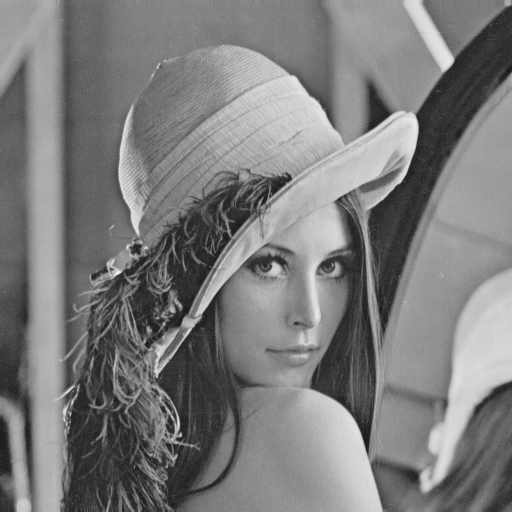

In [17]:
Gray.(lena)

#### Both methods yield the same result. 

## Convolution in the frequency domain

<img src="filterFrequencyDomain.png"> 

<img src="generateHfromh.png">  

<img src="filteringfreqDomainExample.png">   

### Unit function 

In [18]:
function generic_pad_fft(img, filter)
    m, n   = size(img)
    mf, nf = size(filter)
    p      = 2 * m
    q      = 2 * n
    pimg   = zeros(eltype(img), (p,q))
    pflt   = zeros(eltype(filter), (p,q))
    
    pimg[1:m, 1:n]   = img[1:m, 1:n]
    pflt[1:mf, 1:nf] = filter[1:mf, 1:nf]
    
    return pimg, pflt 
end

# specializations 

fft_pad(img::Array{Float64}, filter::Array{Float64}) = generic_pad_fft(img, filter)
fft_pad(img::Array{Int64},   filter::Array{Int64})   = generic_pad_fft(img, filter)

fft_pad (generic function with 2 methods)

In [51]:
function generic_unpad(pimg, imgSize)
    m, n   = imgSize
    img  = zeros(eltype(pimg), (m,n))
    for j in 1:m
        for i in 1:n
            #img[i,j] = pimg[i,j] * (-1)^(i+j)
            img[i,j] = pimg[i,j] 
        end
    end
    return img
end
fft_unpad(pimg::Array{Float64}, imgSize::Tuple) = generic_unpad(pimg, imgSize)
fft_unpad(pimg::Array{Float32}, imgSize::Tuple) = generic_unpad(pimg, imgSize)
fft_unpad(pimg::Array{Int64},   imgSize::Tuple) = generic_unpad(pimg, imgSize)

fft_unpad (generic function with 3 methods)

### Collect into a function

In [20]:
function fft_convolution(img, filter)
    fxyp, wp = fft_pad(img, filter)
    #fft_center_transform!(fxyp)
    #fft_center_transform!(wp)
    Ffxyp=fft(fxyp)
    Fwp = fft(wp)
    Ffxyc = similar(Ffxyp)
    Ffxyc .= Ffxyp .* Fwp 
    fxycp = real(ifft(Ffxyc)) 
    fft_unpad(fxycp, size(img))
end
fft_convolve(img::Array{Float64,2}, filter::Array{Float64,2}) = fft_convolution(img, filter)
fft_convolve(img::Array{Float32}, filter::Array{Float32}) = fft_convolution(img, filter)
fft_convolve(img::Array{Int64}, filter::Array{Int64})     = fft_convolution(img, filter)
fft_convolve(img::Array{Int32}, filter::Array{Int32})     = fft_convolution(img, filter)

fft_convolve (generic function with 4 methods)

### FFT Lena

In [21]:
typeof(lena)

Array{Float64,2}

In [22]:
typeof(gf1)

Array{Float64,2}

In [29]:
@time lena_cfft = fft_convolve(lena, gf1);

  0.443670 seconds (132 allocations: 124.009 MiB, 0.76% gc time)


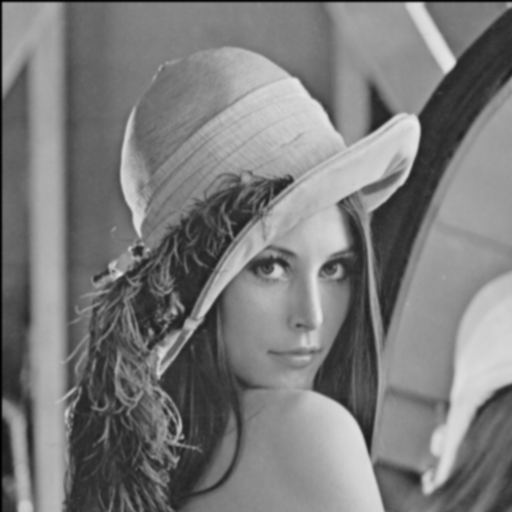

In [30]:
Gray.(lena_cfft)

## GPU

In [32]:
@time lenp, wp = fft_pad(lena, gf1);

  0.005133 seconds (10 allocations: 18.001 MiB)


In [34]:
@time glenap = cu(lenp);

  0.004853 seconds (11 allocations: 4.000 MiB)


In [35]:
@time gwp = cu(wp);

  0.005014 seconds (11 allocations: 4.000 MiB)


In [38]:
@time Fglenap=fft(glenap);

  0.001997 seconds (125 allocations: 3.641 KiB)


In [39]:
@time Fwp=fft(gwp);

  0.020055 seconds (139 allocations: 6.531 KiB)


In [41]:
@time Fglenac = similar(Fglenap);

  0.000494 seconds (15 allocations: 336 bytes)


In [44]:
@time Fglenac .= Fglenap .* Fwp ;

  0.000101 seconds (19 allocations: 576 bytes)


In [46]:
@time glenacp = real(ifft(Fglenac)) ;

  0.001063 seconds (76 allocations: 2.281 KiB)


In [47]:
typeof(glenacp)

CuArray{Float32,2}

In [49]:
@time lenacp = Array(glenacp);

  0.000889 seconds (4 allocations: 4.000 MiB)


In [54]:
@time lena_fft = fft_unpad(lenacp, size(lena));

  0.001247 seconds (3 allocations: 1.000 MiB)


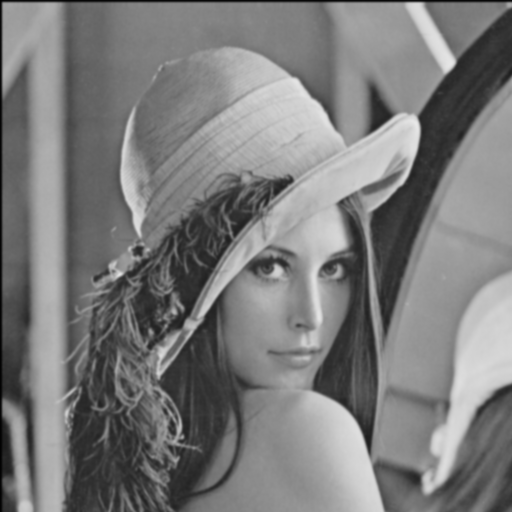

In [55]:
Gray.(lena_fft)

In [56]:
isapprox(lena_cfft, lena_fft)

true

In [57]:
function fft_convolve_gpu(img::Array{Float64,2}, filter::Array{Float64,2})
    imgp, wp = fft_pad(img, filter)
    imgp_cu = cu(imgp)
    wp_cu = cu(wp)
    Fimgp=fft(imgp_cu)
    Fwp = fft(wp_cu)
    Gimgp = similar(Fimgp)
    Gimgp .= Fimgp .* Fwp 
    imgcp_cu = real(ifft(Gimgp)) 
    imgcp = Array(imgcp_cu)
    fft_unpad(imgcp, size(img))
end

fft_convolve_gpu (generic function with 1 method)

In [60]:
@time lena_cf = fft_convolve_gpu(lena, gf1);

  0.044318 seconds (404 allocations: 31.017 MiB, 49.99% gc time)


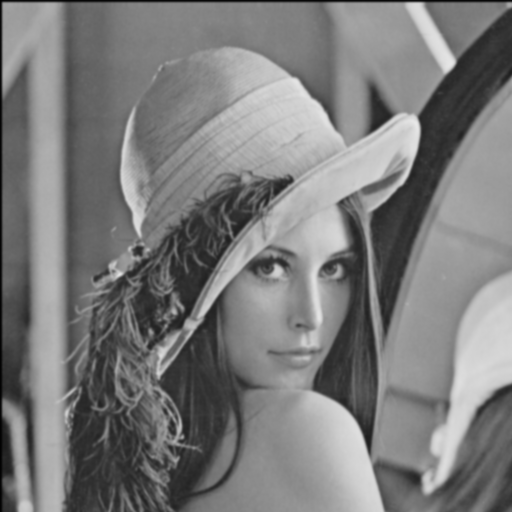

In [61]:
Gray.(lena_cf)

In [64]:
@time lena_g1 = imfilter(lena, reflect(centered(kg1)), Fill(0));

  0.010988 seconds (98 allocations: 4.056 MiB)
